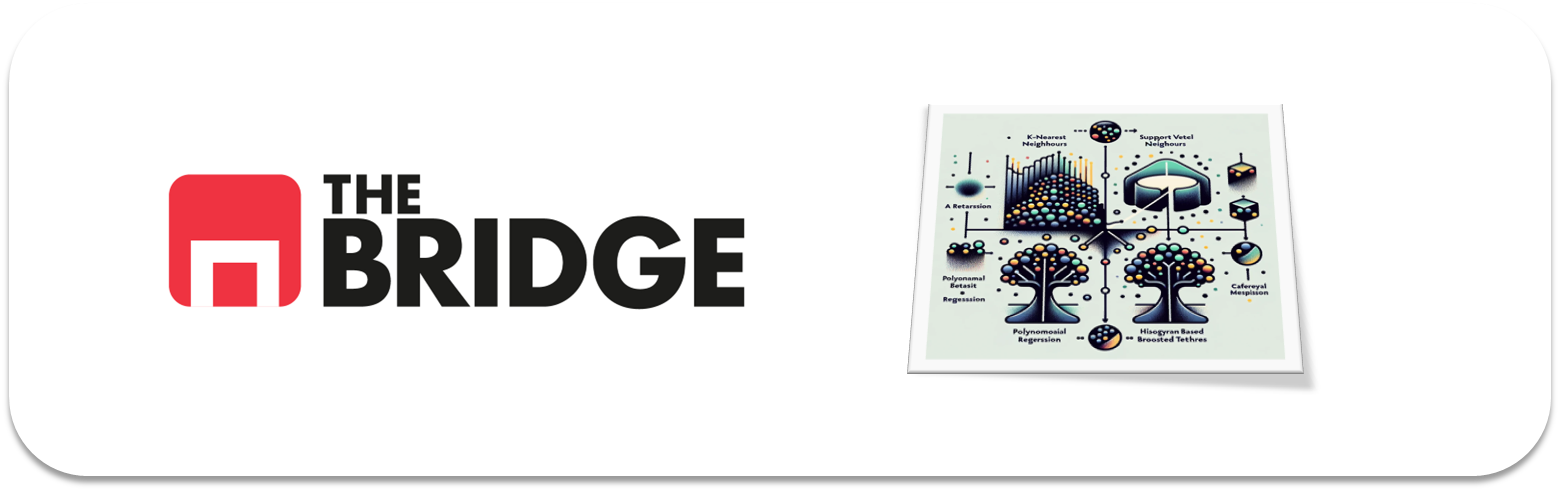

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un     dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [112]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os



from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [53]:
df=pd.read_csv('./data/credit_npo.csv') # Cargamos el data frame.

In [54]:
df.head(10) # Echamos un vistazo a los datos.

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
5,0,0.101002,61,0,0.217115,15880.0,5,0,1,0,0.0
6,0,0.222830,60,0,0.907083,1312.0,5,0,0,0,0.0
7,0,0.353443,39,0,0.764309,4000.0,11,0,1,0,2.0
8,0,0.772455,45,0,0.387179,5100.0,5,0,1,0,3.0
9,0,0.116165,44,0,0.160236,10833.0,8,0,1,0,0.0


# Descripción textual de los datos basada en búsquedas por internet.
*SeriousDlqin2yrs*:	Si en los últimos dos años una persona ha estado sin pagar igual o más de 90 días.  Yes = 1, No = 0. Binaria.
*RevolvingUtilizationOfUnsecuredLines*: Saldo total de tarjetas de crédito y líneas de crédito personales, excepto bienes raíces y deudas sin cuotas como préstamos para automóviles, dividido por la suma de los límites de crédito.Ppercentaje en tanto por 1: Numérica.  Float.
*Age*: Edad del prestatario. Numérica. Entera.
*NumberOfTime30-59DaysPastDueNotWorse*:	Número de veces que el prestatario ha tenido un retraso de entre 30 y 59 días en el pago, pero no más, en los últimos 2 años.	Integer
*DebtRatio*:	Pagos mensuales de deudas, pensión alimenticia, costes de vida divididos por el ingreso bruto mensual.	Porcentaje. Float
*MonthlyIncome*	Ingreso mensual.	Numérica real.
*NumberOfOpenCreditLinesAndLoans*	Número de préstamos abiertos (préstamos a plazos, préstamos para automóviles o hipotecas) y líneas de crédito (por ejemplo, tarjetas de crédito).	Entera
*NumberOfTimes90DaysLate*	Número de veces que el prestatario ha tenido un retraso de 90 días o más en el pago. Entera.
*NumberRealEstateLoansOrLines*	Número de préstamos hipotecarios e inmobiliarios, incluidas líneas de crédito con garantía hipotecaria.	Entera.
*NumberOfTime60-89DaysPastDueNotWorse*	Número de veces que el prestatario ha tenido un retraso de entre 60 y 89 días en el pago, pero no más, en los últimos 2 años.	Entera
*NumberOfDependents* :Número de dependientes en la familia, excluidos ellos mismos (cónyuge, hijos, etc.). Entera.

In [55]:
# Usamos esta función que teniamos ya creada para clasificar las variables.
def tipifica_variables(df, umbral_categoria, umbral_continua):
    '''
    Esta función sirve para poder tipificar las variables de un DF dado en categórica, numerica continua o numerica discreta.

    Argumentos:
    df (pd.DataFrame): DF original para adquirir las variables que se quiera tificar.
    umbral_categoria (int): un entero donde corresponda al umbral que queramos asignar a una variable categórica.
    umbral_continua (float): un float donde corresponda al umbral que queramos asignar a una variable numérica.

    Retorna:
    pd.DataFrame: Un DF con dos columnas 'nombre_varibale' y 'tipo_sugerido', que tendrá tantas filas como columnas haya en el DF original.
    '''

    if type(umbral_categoria) != int:
        raise TypeError(f'El valor de "umbral_categoria" debe ser de tipo {int}, pero recibió de tipo {type(umbral_categoria)}')

    elif type(umbral_continua) != float:
        raise TypeError(f'El valor de "umbral_continua" debe ser de tipo {float}, pero recibió de tipo {type(umbral_continua)}')

    else:

        df_tipificacion = pd.DataFrame({
            'nombre_variable': df.columns
        })

        df_tipificacion['tipo_sugerido'] = ''

        for i, val in df_tipificacion['nombre_variable'].items():
            card = df[val].nunique()
            porcentaje = df[val].nunique()/len(df) * 100

            if card == 2:
                df_tipificacion.at[i,'tipo_sugerido'] = 'Binaria'
            
            elif card < umbral_categoria:
                df_tipificacion.at[i,'tipo_sugerido'] = 'Categórica'
        
            else:
                if porcentaje > umbral_continua:
                    df_tipificacion.at[i, 'tipo_sugerido'] = 'Numérica Continua'
                else:
                    df_tipificacion.at[i, 'tipo_sugerido'] = 'Numérica Discreta'
    
    return df_tipificacion



In [56]:
tipifica_variables(df, 7, 5.0) # Llamamos a la función para que nos clasifique las variables.

,nombre_variable,tipo_sugerido
0,SeriousDlqin2yrs,Binaria
1,RevolvingUtilizationOfUnsecuredLines,Numérica Continua
2,age,Numérica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,Numérica Discreta
4,DebtRatio,Numérica Continua
5,MonthlyIncome,Numérica Continua
6,NumberOfOpenCreditLinesAndLoans,Numérica Discreta
7,NumberOfTimes90DaysLate,Numérica Discreta
8,NumberRealEstateLoansOrLines,Numérica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,Numérica Discreta


In [57]:
df.NumberOfDependents.value_counts() # Veamos los valores de una de las numéricas discretas.

NumberOfDependents
0.0     6935
1.0     2384
2.0     1816
3.0      882
4.0      253
5.0       62
6.0       24
8.0        2
10.0       1
7.0        1
Name: count, dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [59]:
print(len(df.columns.to_list())) # veamos cuántas oclumnas tiene

11


Vemos que tenemos algunos nulos  en 'MonthlyIncome' y 'NumberOfDependents'. Y tiene 11 columnas.
 

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Parece que el target sería 'SeriousDlqin2yrs' y que estamos ante un problema de clasificación.

In [60]:
df.SeriousDlqin2yrs.value_counts()

SeriousDlqin2yrs
0    11673
1      864
Name: count, dtype: int64

### #1.3 Pinta la distribución de frecuencias del target y coméntala

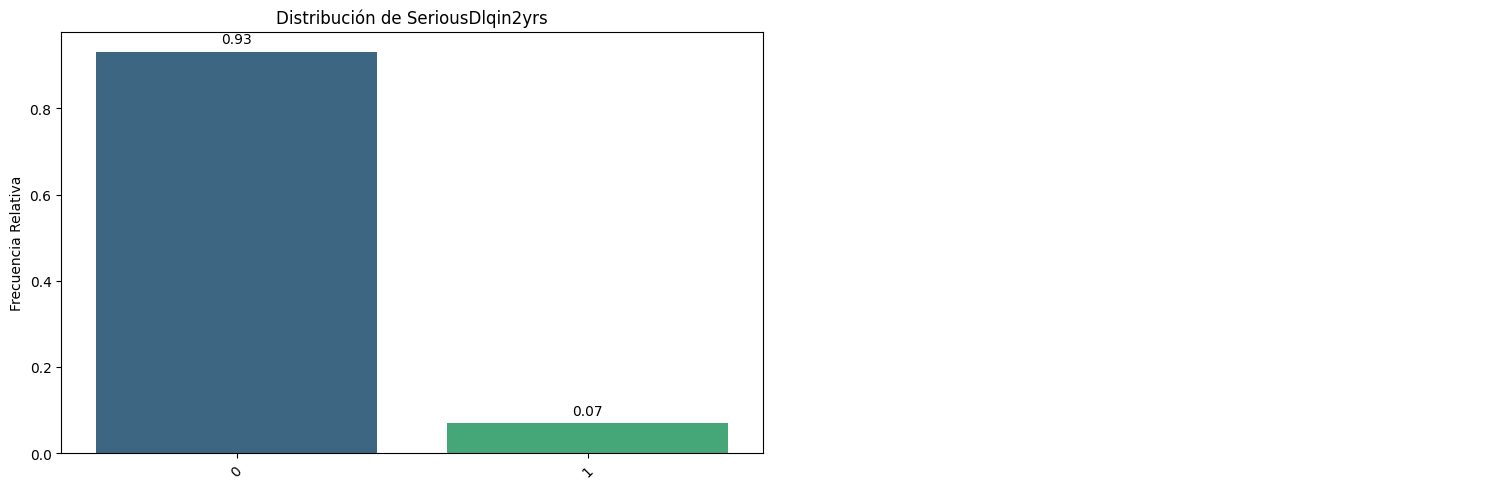

In [61]:
bt.pinta_distribucion_categoricas(df, ["SeriousDlqin2yrs"], mostrar_valores= True, relativa= True) 

Vemos que la variable objetivo está muy desbalanceada.

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [62]:
target = "SeriousDlqin2yrs" # Fijamos la variable objetivo.

Vemos que la features MonthlyIncome y NumberOfDependents tienen nulos. Como no nos atrevemos a contaminar la muestra probamos a eliminar esas filas antes de hacer la separación entre train y set.

In [63]:
df_2= df.dropna()

In [64]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [65]:
df_2.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000
mean,0.070244,0.335668,51.447698,0.340471,0.499708,6864.815420,8.759140,0.180010,1.059580,0.149712,0.856804
std,0.255568,0.365209,14.516270,2.927409,2.696067,11855.905437,5.129772,2.892577,1.140716,2.868248,1.147509
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034927,41.000000,0.000000,0.143456,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179183,51.000000,0.000000,0.294748,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587187,62.000000,0.000000,0.477414,8300.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,6.000000,101.000000,98.000000,96.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [66]:
# Hagamos la separacion entre train y test

train_set, test_set = train_test_split(df_2, test_size= 0.2, random_state= 42)


In [67]:
train_set.describe() # Vemos si se ha creado bien

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.070144,0.335207,51.491536,0.343314,0.486047,6868.428058,8.794647,0.180279,1.064325,0.152772,0.863415
std,0.255403,0.362233,14.499298,2.930489,2.505031,12580.543336,5.139555,2.889984,1.148156,2.870119,1.158238
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034869,41.000000,0.000000,0.146204,3466.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179211,51.000000,0.000000,0.297564,5441.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587533,62.000000,0.000000,0.477876,8300.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,6.000000,101.000000,98.000000,96.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [68]:
test_set.describe() # Vemos si se ha creado bien

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000
mean,0.070643,0.337515,51.272420,0.329103,0.554328,6850.370981,8.617174,0.178934,1.040609,0.137479,0.830372
std,0.256282,0.376944,14.585696,2.915654,3.352920,8354.573813,5.089073,2.903535,1.110505,2.861326,1.103409
min,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035720,40.000000,0.000000,0.134350,3500.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.178774,51.000000,0.000000,0.281021,5311.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.581056,62.000000,0.000000,0.474404,8301.500000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,5.347652,97.000000,98.000000,91.500000,237490.000000,43.000000,98.000000,11.000000,98.000000,6.000000


# EDA
Vamos a hacer un pequeño EDA para analizar las variables features y sus correlaciones tanto entre sí como el target. 

In [69]:
features_num = train_set.columns.to_list() # Creamos la lista de features para usarla en los pairplots.
features_num.remove(target) # Aunque luego lo iré añadiendo para ir comparando con el target
print(len(features_num)) 

10


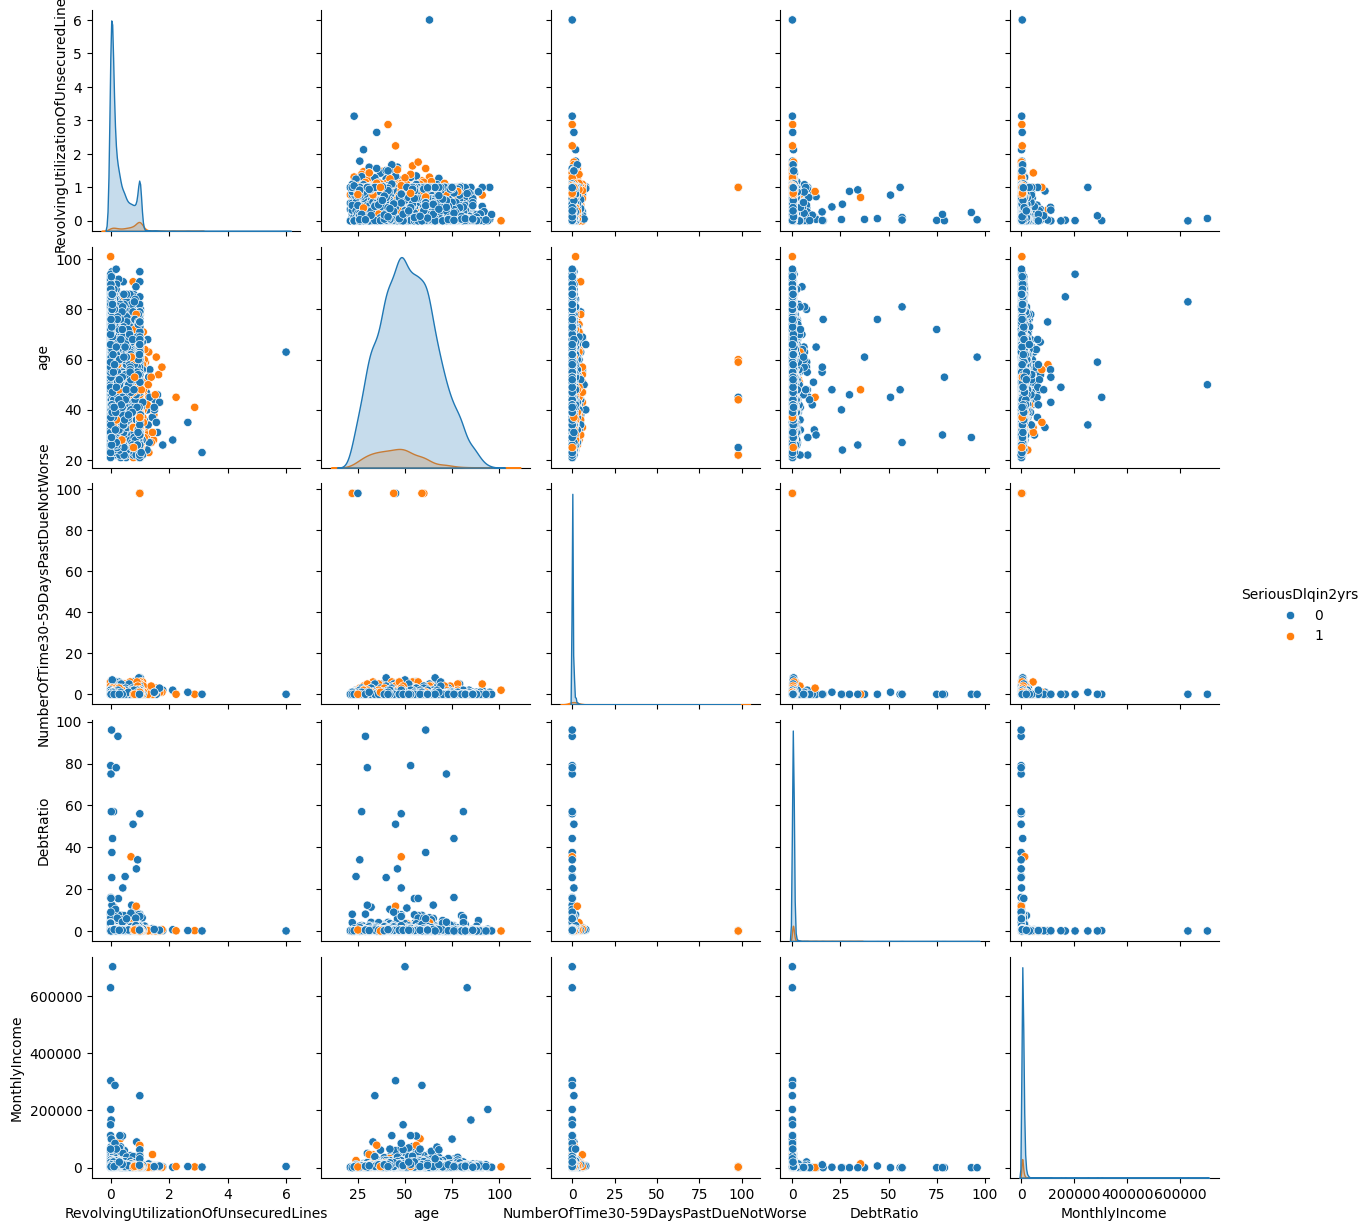

In [70]:
# Vamos a hacer pairplots de seaborn, con el hue asignado a la variable target. De 5 en 5 porque tenemos 10 variables.
sns.pairplot(train_set[features_num[0:5] + [target]], hue = target) #añadimos el target a los datos y lo asingamos al hue,1 para los que han impagado al menos 90 días en los últimos dos años y 0 para resto.


Parecen todas interesantes, no se aprecian correlaciones entre ellas casi.
Ya vemos algunas con distribuciones muy agrupadas y algunos valores atípicos que pueden enturbiar, sobre todo si hacemos regresión logística o KNNs....habrá que tratarlas.

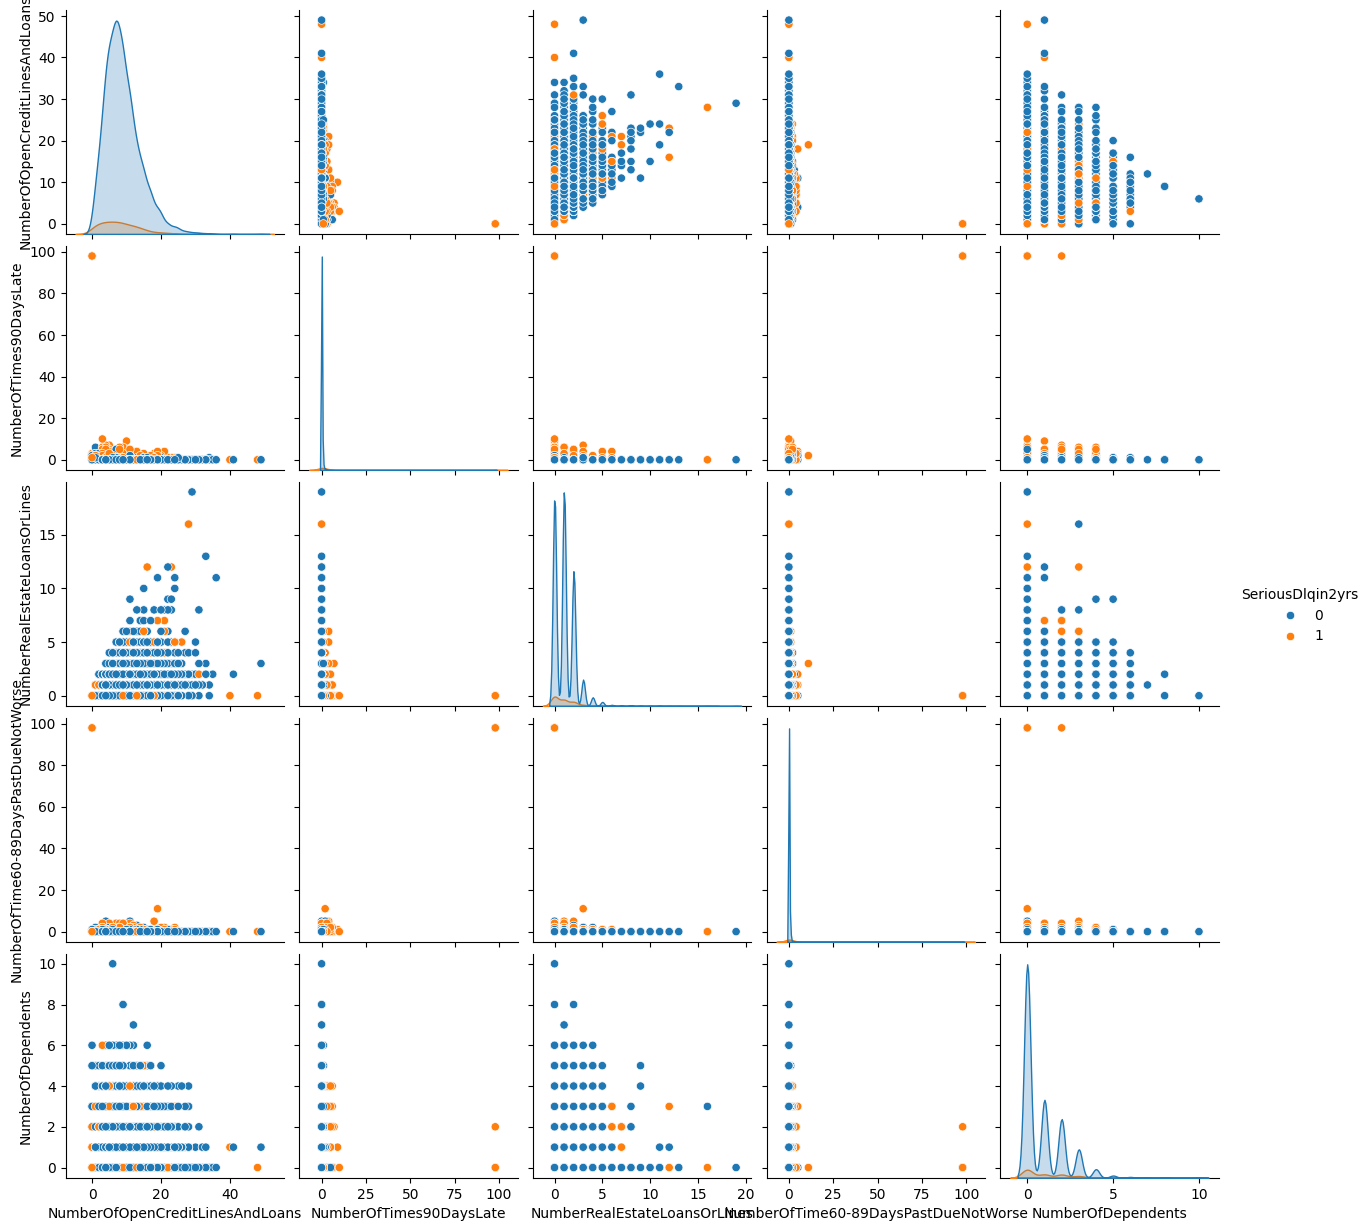

In [71]:
sns.pairplot(train_set[features_num[5:10] + [target]], hue = target) 

Volvemos a ver valores atípicos en algunas variables.

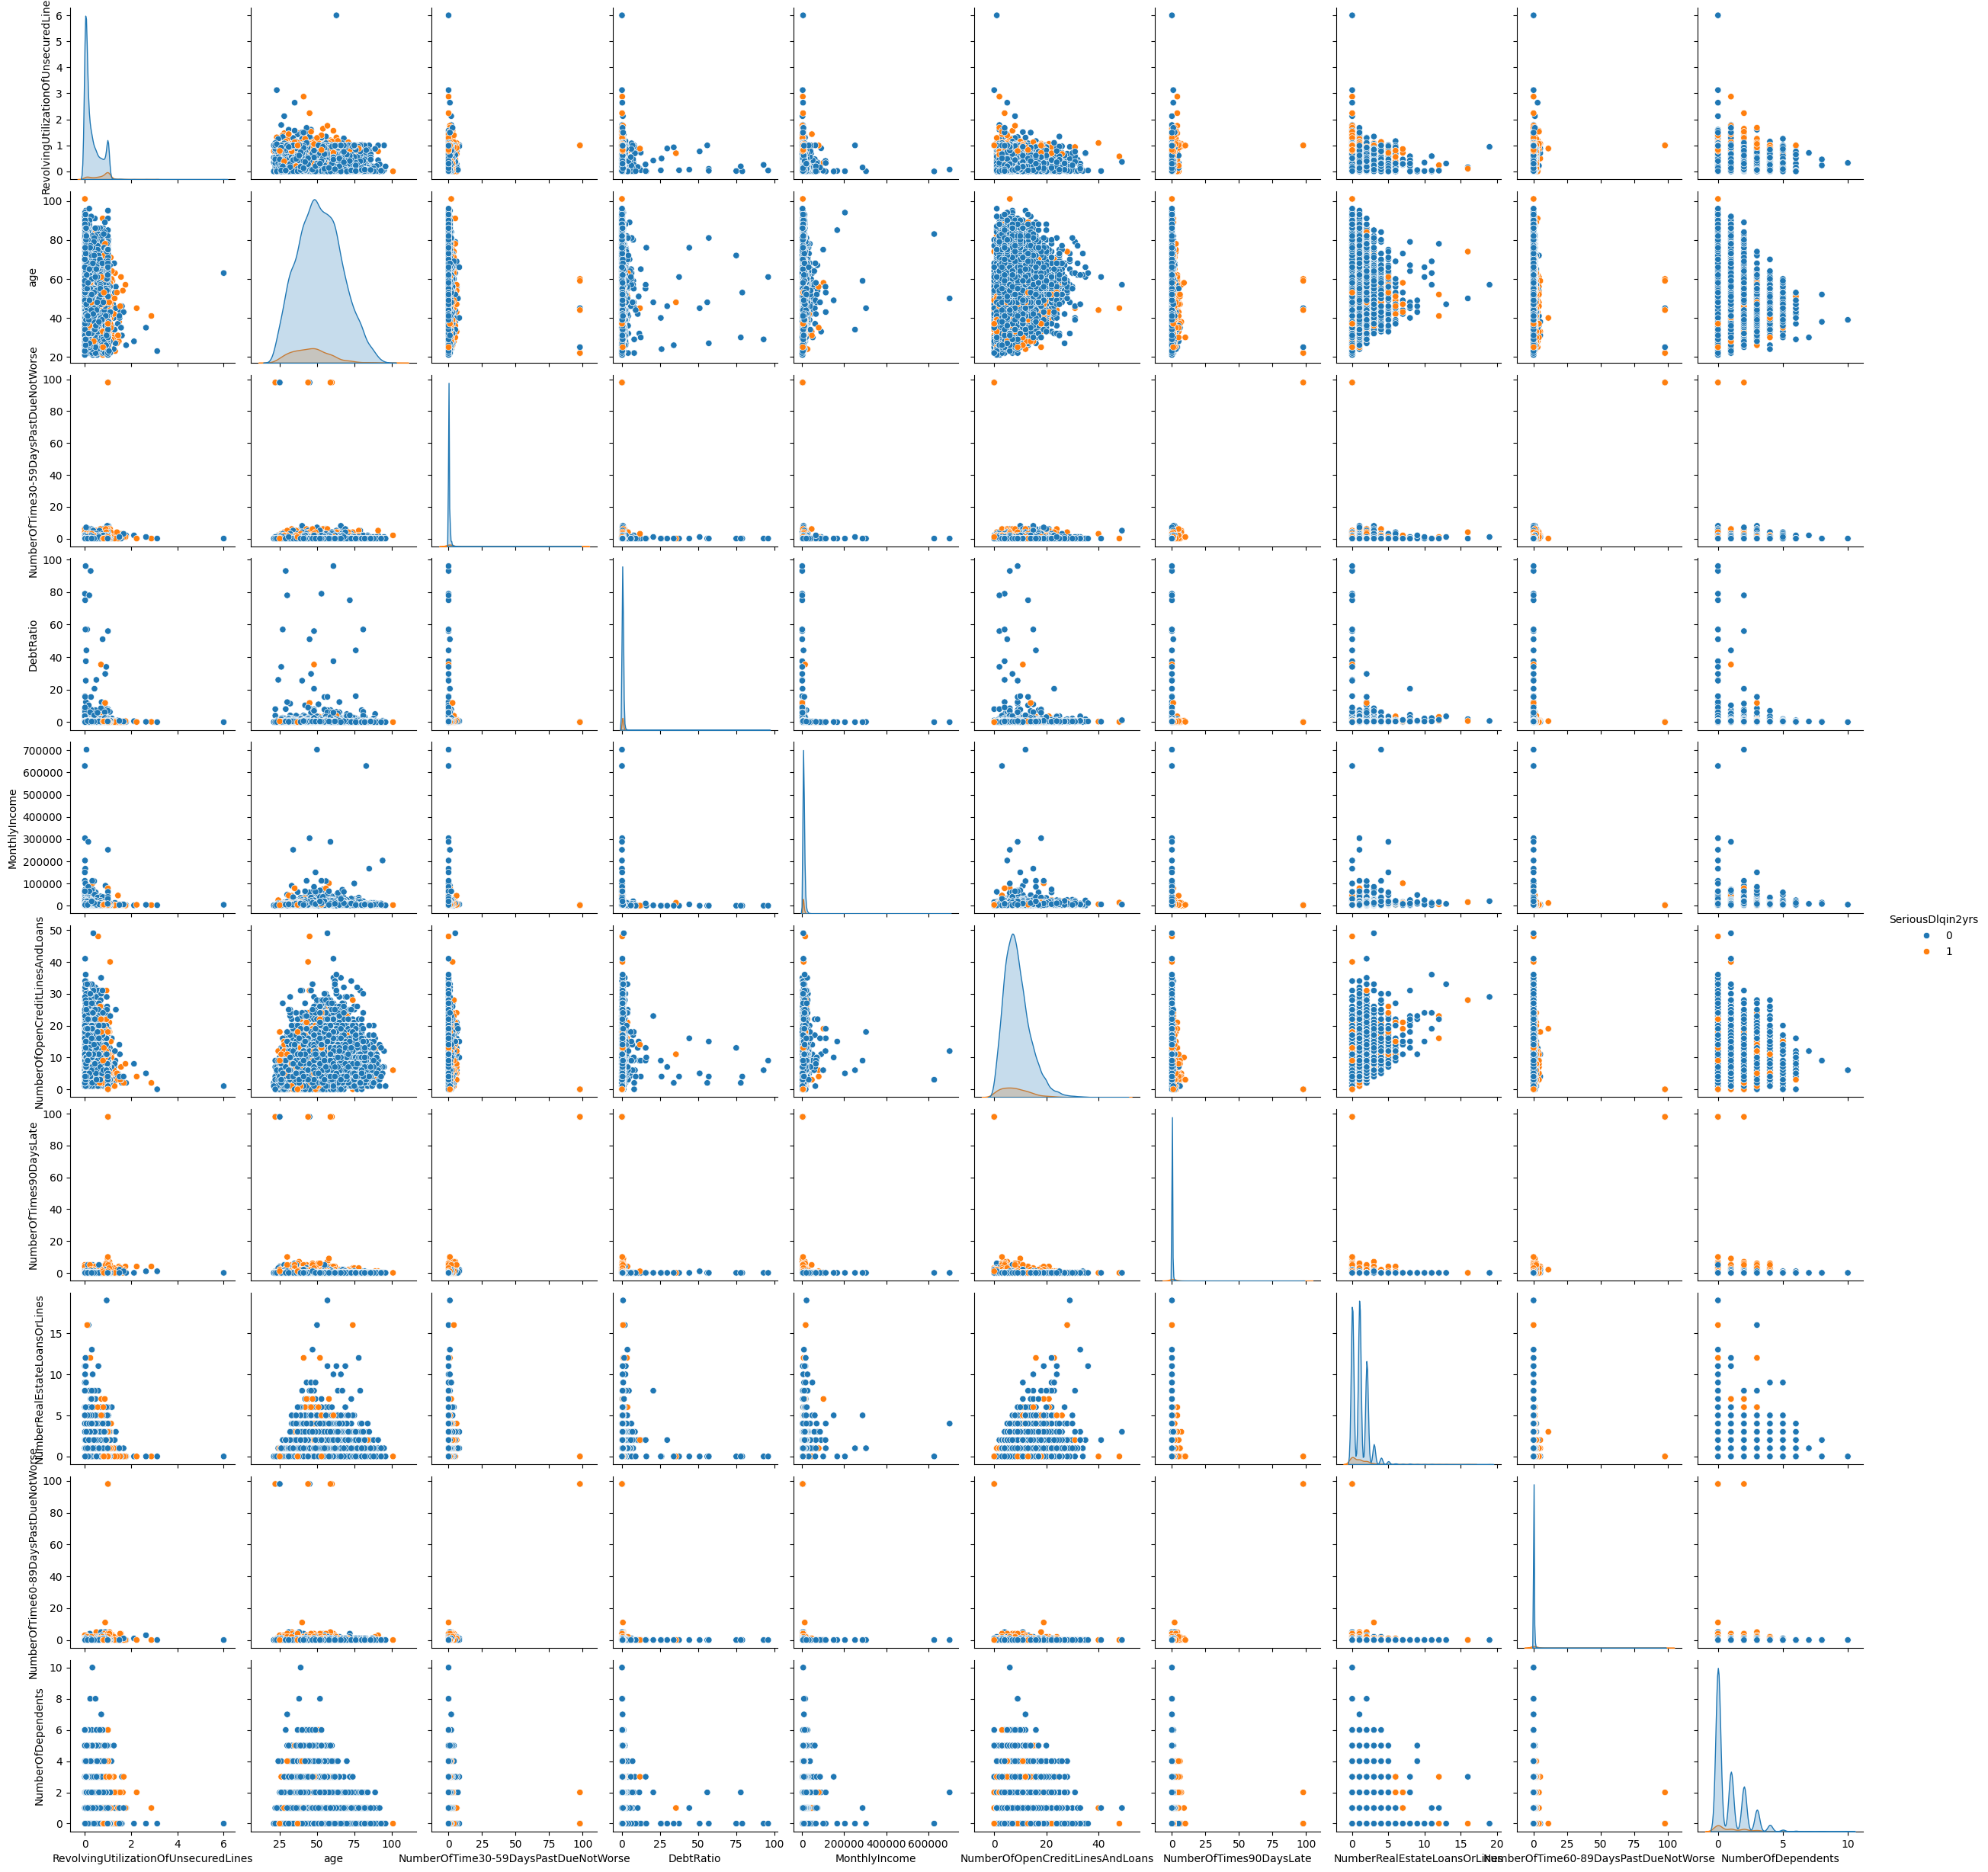

In [72]:
sns.pairplot(train_set[features_num[0:10] + [target]], hue = target) # Veamos un pairplot con todas las variables....que al fin y al cabo no son tantas.

In [73]:
print(features_num)


['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [74]:
# Vamos a ver la correlación entre algunas featuores relacionadas con los días de impago.
features_past_due = ["NumberOfTime30-59DaysPastDueNotWorse","NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"]
corr=train_set.corr(numeric_only=True)
corr[features_past_due].loc[features_past_due]


,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse,1.000000,0.966865,0.970365
NumberOfTimes90DaysLate,0.966865,1.000000,0.984354
NumberOfTime60-89DaysPastDueNotWorse,0.970365,0.984354,1.000000


Como esperábamos tienen una fuerte correlación entre ellas, veamos su distribución vs la variable target. 
Veamos otras posibles correlaciones entre las relacionadas con crédito, deuda, etc.

In [75]:
features_debts =['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines', 'NumberOfDependents']
corr[features_debts].loc[features_debts]

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
RevolvingUtilizationOfUnsecuredLines,1.000000,0.010163,-0.161180,-0.089913,0.070510
DebtRatio,0.010163,1.000000,0.034363,0.040832,-0.007572
NumberOfOpenCreditLinesAndLoans,-0.161180,0.034363,1.000000,0.429687,0.029077
NumberRealEstateLoansOrLines,-0.089913,0.040832,0.429687,1.000000,0.109326
NumberOfDependents,0.070510,-0.007572,0.029077,0.109326,1.000000


Nos hemos equivocado, estas no están correladas entre ellas. Deberíamos usarlas todas.

# Vamos a tratar las features
Como vamos a usar el KNN y random forest y regresión logística. Para el primero y el tercero necesitamos normalizar y homogeneizar las features.
Primero haremos una transformación usando una transformación logarítmica para "normalizar" la distribución.
Luego aplicaremos un escalado.

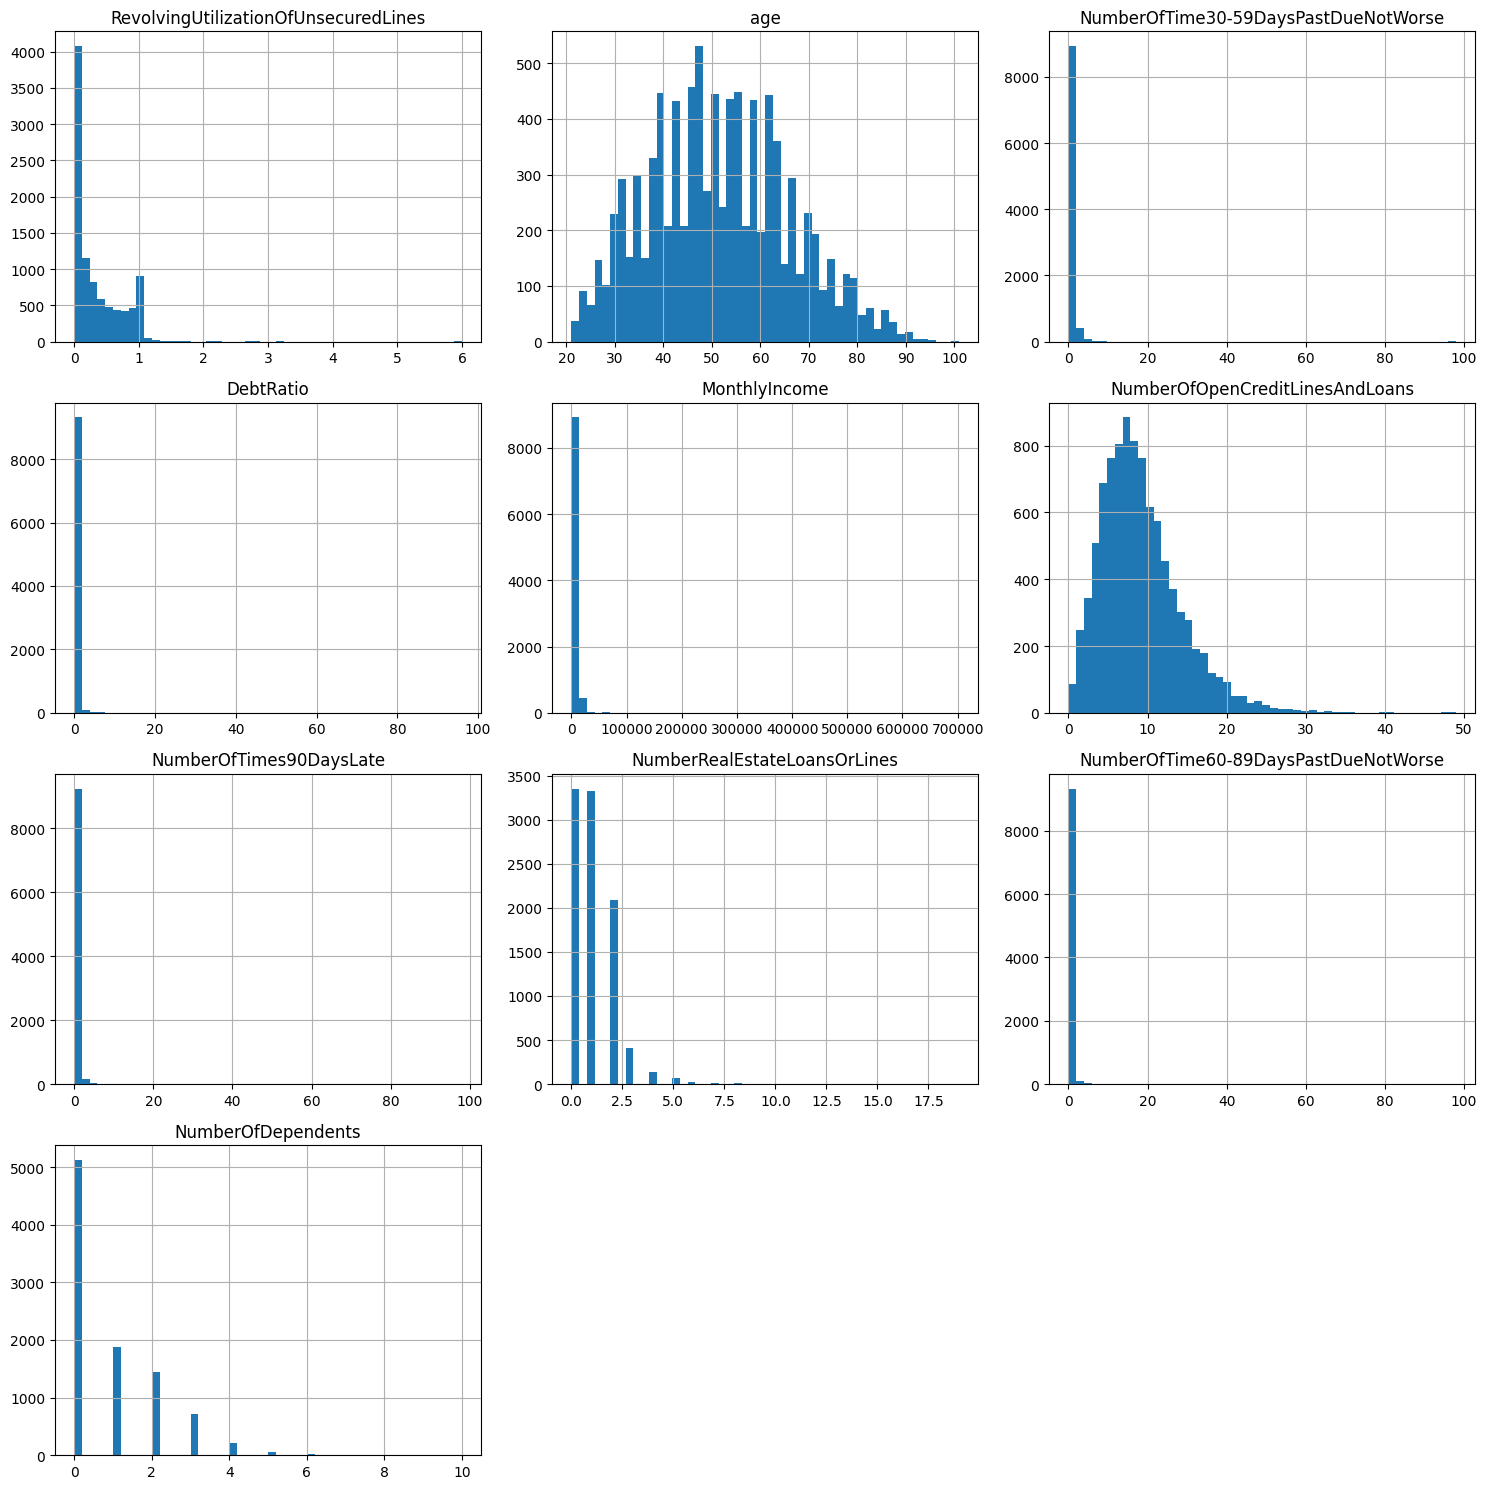

In [76]:
train_set[features_num].hist(figsize = (15,15),bins=50)
plt.tight_layout()

In [77]:
# Vamos a aplicar una transformación logarítmica a aquellas que se agrupa a la derecha o la izquierda de la distribución. Son todas muchas, como ya habíamos visto en los pairplots.
features_to_log = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [78]:
# Hacemos una copia para transformar de los sets.
train_set_scaled = train_set.copy() 
test_set_scaled = test_set.copy()

In [79]:
print(train_set_scaled.columns)


Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


In [80]:
# En este caso hemos visto que no hay mínimos negativos aun así le aplicamos el desplazamiento sobre el mínimo de cada columna.
for col in features_to_log:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)


In [81]:
# Ahora hacemos el escalado
scaler = StandardScaler()
train_set_scaled[features_num] = scaler.fit_transform(train_set_scaled[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_scaled[features_num])

In [96]:
# definimos los grupos X e y quitando en el segundo la variable target.
X_train = train_set_scaled.drop("SeriousDlqin2yrs", axis = 1)
X_test = test_set_scaled.drop("SeriousDlqin2yrs", axis = 1)
y_train = train_set_scaled["SeriousDlqin2yrs"]
y_test = test_set_scaled["SeriousDlqin2yrs"]

In [98]:
# Vamos a empezar con el modelo KNN

n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [99]:
print(classification_report(y_train, knn.predict(X_train)))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8789
           1       0.71      0.28      0.40       663

    accuracy                           0.94      9452
   macro avg       0.83      0.64      0.69      9452
weighted avg       0.93      0.94      0.93      9452



In [100]:
# Vamos a buscar el número de vecinos y los parámetros mejores.
param_grid = {
    "n_neighbors": range(1,20),
    "weights": ["uniform","distance"]
}

knn_grid = GridSearchCV(knn, 
                        param_grid = param_grid,
                        cv = 5,
                        scoring = "balanced_accuracy")

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [101]:
knn_grid.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [102]:
knn_grid.best_score_

0.6179853027366513

Vemos que para este modelo el recall es bajísimo....veamos con otros modelos.

In [103]:
# Hagamos una regresión logística.
lr_clf = LogisticRegression(max_iter = 1000)

In [104]:
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [105]:
print(classification_report(y_train, lr_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      8789
           1       0.61      0.19      0.29       663

    accuracy                           0.93      9452
   macro avg       0.78      0.59      0.63      9452
weighted avg       0.92      0.93      0.92      9452



Los resultados son peores.


In [108]:
# Vamos  hacer un RandomForesst.

rf_clf = RandomForestClassifier(max_depth= 6, random_state= 42)

In [109]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [110]:
print(classification_report(y_train, rf_clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8789
           1       0.94      0.21      0.34       663

    accuracy                           0.94      9452
   macro avg       0.94      0.60      0.66      9452
weighted avg       0.94      0.94      0.93      9452




Los datos de recall para el resultado 1 son muy malos también.

In [117]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [118]:
knn_scores = cross_val_score(knn, X_train, y_train, cv=kf)
lgc_scores = cross_val_score(lr_clf,X_train,y_train,cv=kf)
tree_scores = cross_val_score(rf_clf, X_train, y_train, cv=kf)





In [121]:
print(f"KNN Accuracy: {knn_scores.mean():.5f} (+/- {knn_scores.std() * 2:.2f})")
print(f"Logistical Regresion Accuracy: {lgc_scores.mean():.5f} (+/- {lgc_scores.std() * 2:.2f})")
print(f"Decision Random Forest Accuracy: {tree_scores.mean():.5f} (+/- {tree_scores.std() * 2:.2f})")

KNN Accuracy: 0.92700 (+/- 0.01)
Logistical Regresion Accuracy: 0.93430 (+/- 0.01)
Decision Random Forest Accuracy: 0.93430 (+/- 0.01)


Escogeríamos la regresión logística.


In [ ]:
# NO ME HA DADO TIEMPO A HACER EL ANÁLSIS DE ERRORES NI EL AJUSTE DE HIPERPARÁMETROS AUNQEU EL MODLO DE REGRERIÓN LOGÍSTICA YA LO TOQUÉ N LA PRIMERA FASE...IGUAL ME ANTICIPÉ. 